Diego Fernando Landeros Austria
A01751654

#**Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)**


##Introducción

En el campo de la medicina, la detección temprana y precisa de tumores cerebrales es un desafío crítico. Exsite una gran dificultad en la clasificación precisa de tumores cerebrales, esto ha llevado al desarrollo de sistemas y técnicas más avanzadas y precisas. Con esto en mente, las redes neuronales se presentan como una herramienta con gran potencial para la identificación y clasificación de estos tumores.

La relevancia del proyecto nace de la capacidad de mejorar la precisión de diagnóstico de tumores cerebrales, lo que puede conducir a tratamientos más tempranos y, en consecuencia, más eficaces. La tardanza en la detección de tumores en general generalmente resulta en un tratamiento inadecuado y un pronóstico menos favorable para el paciente.
Por tanto, el desarrollo de un modelo capaz de distinguir entre cerebros sanos y cerebros con tumores es importante en el área medica y puede marcar una diferencia en la vida de los pacientes.

##Descarga del dataset y preparación de los conjuntos

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import random
import matplotlib.image as mpimg

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics import F1Score
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [35]:
#Configuración del acceso a kaggle para descargar el dataset
!mkdir -p /root/.kaggle
!cp "/content/drive/MyDrive/7 Semestre/Parte 2/Blumenkron/kaggle.json" /root/.kaggle/

In [36]:
#Descarga y descompresión del dataset
!kaggle datasets download -d preetviradiya/brian-tumor-dataset
path = "/content/brian-tumor-dataset.zip"
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall("/content/" )

brian-tumor-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


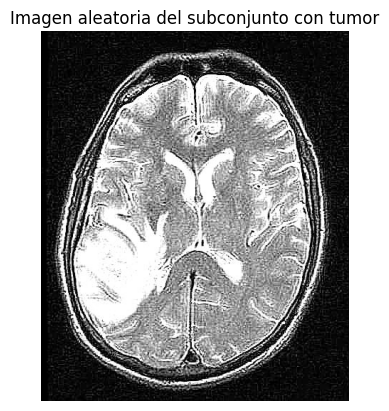

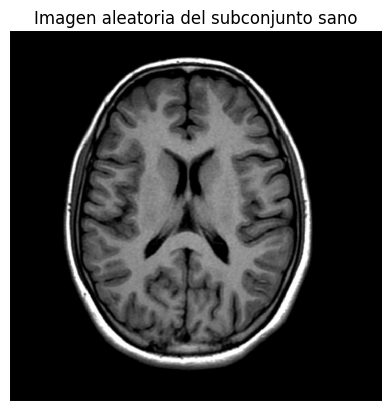

In [37]:
#Imprimir imagenes aleatorias de cada directorio/categoría
image = random.choice(os.listdir('/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'))
image=os.path.join('/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor', image)
img = mpimg.imread(image)
plt.imshow(img)
plt.axis('off')
plt.title('Imagen aleatoria del subconjunto con tumor')
plt.show()

image = random.choice(os.listdir('/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'))
image=os.path.join('/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy', image)
img = mpimg.imread(image)
plt.imshow(img)
plt.title('Imagen aleatoria del subconjunto sano')
plt.axis('off')
plt.show()

In [38]:
#Se usa la liberia de split-folders para hacer la división de conjuntos en
#entrenamiento, validación y prueba
!pip install split-folders
!split-folders '/content/Brain Tumor Data Set/Brain Tumor Data Set' --output train_data --ratio 0.7 0.3 --seed 6
!split-folders '/content/train_data/val' --output test_val_data --ratio 0.5 0.5 --seed 6



Copying files: 4600 files [00:00, 5038.13 files/s]
Copying files: 1381 files [00:00, 4107.46 files/s]


In [39]:
#Uso de herramientas de keras para crear los dataset de entrenamiento, validación y prueba desde los directorios
train_dir = '/content/train_data/train'
val_dir = '/content/test_val_data/val'
test_dir = '/content/test_val_data/train'
batch_size = 32  # Tamaño del lote
image_size = (256, 256)  # Tamaño de las imágenes
# Carga de datos de entrenamiento desde el directorio
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=6,label_mode='binary', labels='inferred'
)
val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=6, label_mode='binary', labels='inferred'
)

test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=6, label_mode='binary', labels='inferred'
)

# Visualización de las clases para confirmar que se crearon correctamente los datasets
class_names, val_classes, test_classes = train.class_names, val.class_names, test.class_names
print("Clases:", class_names, val_classes, test_classes)

Found 3161 files belonging to 2 classes.
Found 676 files belonging to 2 classes.
Found 677 files belonging to 2 classes.
Clases: ['Brain Tumor', 'Healthy'] ['Brain Tumor', 'Healthy'] ['Brain Tumor', 'Healthy']


##Primer modelo (Arquitectura de CNN básica)

Para la red neuronal, dada la problematica basada en la clasificación de imagenes se decidio usar una red neuronal convoluciones, ya que este tipo de arquitecturas son especialmente útiles para reconocer patrones en imágenes.
Primero se decidió crear un modelo con una arquitectura sencilla, con hiperparametros base para tener una base sobre la cual trabajar y poder mejorar la red posteriormente utilizando técnicas de regularización, modificación de la estructura o usando hiperparametros.

Se creó un modelo secuencial, la primera capa es una capa de convolución a la que se le indica el tamaño de entrada de la imagen, por comodidad se usaran potencias de 2 en el número de neuronas en las capa de convolución y densa.
Después de las capas de convolución se utilizan capas de pooling para reducir la dimensionalidad y controlar el número de parámetros a entrenar

In [40]:
#Primera versión del modelo con una arquitectura básica
model = Sequential(name='BrainTumorDetector')
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.summary()

Model: "BrainTumorDetector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 128)        

Además, usaremos el optimizador Adam con parametros default, como función de pérdida usaremos binary_crossentropy y para evaluar la red usaremos la métrica F1, que es muy comunmente usada en este tipo de problemas ya que es sumamanete importante clasificar correctamente, tanto positivos como negativos.

Usaremos 30 epocas para entrenar la red y evaluaremos su desemepeño al final del entrenamiento

In [42]:
optimizer = Adam()
loss = binary_crossentropy
metric = F1Score(threshold=0.5)
#metrics = CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [43]:
history = model.fit(train, epochs=30,validation_data=val)

Epoch 1/30
99/99 [==============================] - 16s 126ms/step - loss: 130.4226 - f1_score: 0.7214 - val_loss: 0.2726 - val_f1_score: 0.9058
Epoch 2/30
99/99 [==============================] - 15s 143ms/step - loss: 0.1088 - f1_score: 0.9639 - val_loss: 0.1510 - val_f1_score: 0.9496
Epoch 3/30
99/99 [==============================] - 8s 73ms/step - loss: 0.0256 - f1_score: 0.9945 - val_loss: 0.1609 - val_f1_score: 0.9709
Epoch 4/30
99/99 [==============================] - 10s 93ms/step - loss: 0.0080 - f1_score: 0.9983 - val_loss: 0.1686 - val_f1_score: 0.9609
Epoch 5/30
99/99 [==============================] - 9s 89ms/step - loss: 0.0025 - f1_score: 1.0000 - val_loss: 0.1774 - val_f1_score: 0.9692
Epoch 6/30
99/99 [==============================] - 9s 85ms/step - loss: 7.0181e-04 - f1_score: 1.0000 - val_loss: 0.2019 - val_f1_score: 0.9676
Epoch 7/30
99/99 [==============================] - 9s 91ms/step - loss: 3.0936e-04 - f1_score: 1.0000 - val_loss: 0.2201 - val_f1_score: 0.964

Gráficando el historial de entrenamiento de la red podemos observar que tiene un aprendizaje rápido y solo existe perdida significativa del modelo en la primera epoca, sin embargo la perdida significativa solo existe en el conjunto de entrenamiento.
En cuanto a la métrica de evaluación F1 Score observamos que se observa una mejoríaen el desempeño del modelo de manera rápida y el modelo converge poco después de 5 épocas.
Sin embargo, observamos que el modelo llega al 100% en el F1 Score, algo bastante inusual en este tipo de problemas. A continuación usaremos el conjunto de prueba para poder llegar a conclusiones finales sobre el modelo

<Axes: title={'center': 'Loss vs Epoch'}>

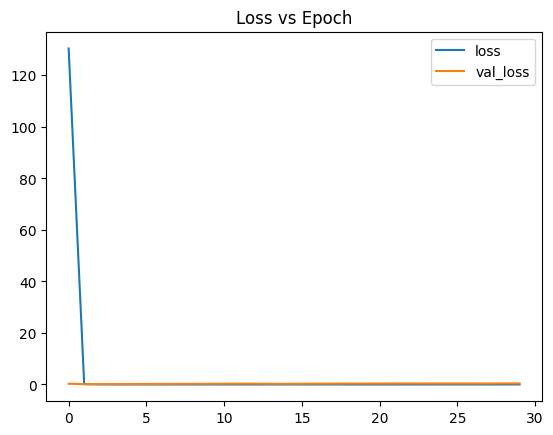

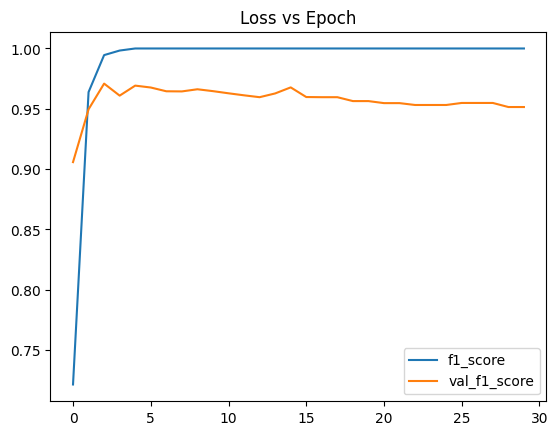

In [44]:
df = pd.DataFrame(history.history)
df['f1_score'] = df['f1_score'].apply(lambda x: x[0])
df['val_f1_score'] = df['val_f1_score'].apply(lambda x: x[0])
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")
df.plot(y=["f1_score", "val_f1_score"], title="Loss vs Epoch")

###Resultados en el conjunto de prueba

1/1 [==============================] - 0s 93ms/step


F1-score en el conjunto de prueba: 0.98


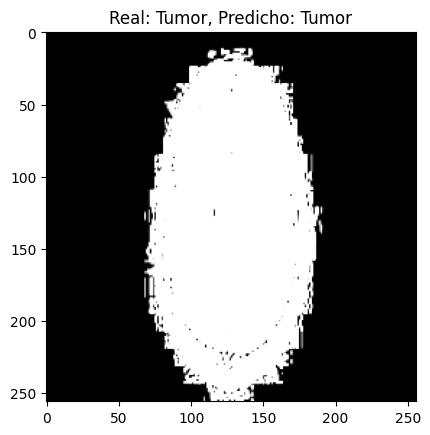

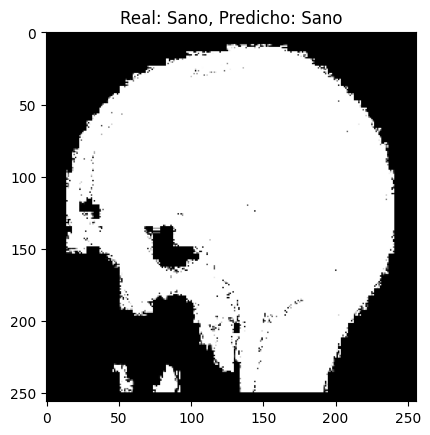

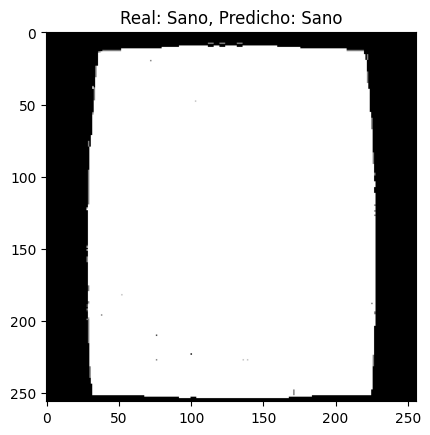

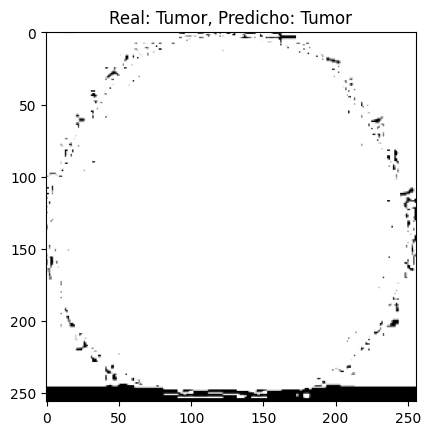

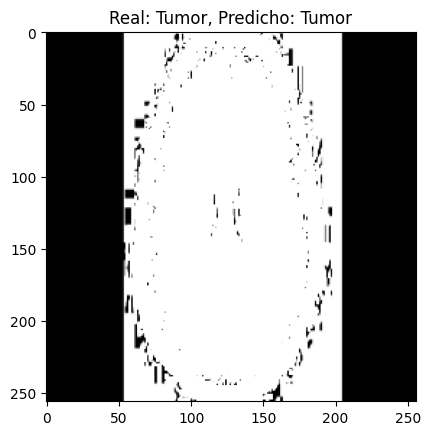

In [45]:
images = []
true_labels = []
predicted_labels = []
for x, y in test:
    predictions = model.predict(x)
    images.extend(x)
    true_labels.extend(y)
    predicted_labels.extend(predictions)

true_binary_labels = [1 if label[0] == 1 else 0 for label in true_labels]
predicted_binary_labels = [1 if label[0] >= 0.5 else 0 for label in predicted_labels]
f1 = f1_score(true_binary_labels, predicted_binary_labels)
print(f'F1-score en el conjunto de prueba: {f1:.2f}')
for i in range(5):
    image = images[i]
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]
    true_class = 'Tumor' if true_label[0] == 1 else 'Sano'
    predicted_class = 'Tumor' if predicted_label[0] >= 0.5 else 'Sano'
    plt.imshow(image)
    plt.title(f'Real: {true_class}, Predicho: {predicted_class}')
    plt.show()

Depués de realizar predicciones y evaluar el conjunto de prueba llegamos a la conclusión de que, efectivamente el modelo tiene un buen desempeño con puntajes de 100%, 96% y 95% en los conjuntos de entrenamiento, validación y prueba respectivamente. Podemos considerar que tiene un comportamiento inusual por el puntaje perfecto en el conjunto de entrenamiento ya que por la naturaleza del problema esto no debería ser posible, podemos considerar un mínimo overfitting en el modelo,por esto para mejorar el modelo vamos a agregar herramientas contra el overfitting, modificaciones en el learning rate y evitaremos que se sobreentrene si se alcanza convergencia.

##Modelo mejorado

Después de iterar por varios modelos, agregando capas de batch normalziation, dropout, cambios en el optimizador e incluso cambios completos de la arquitectura de la red se llegó a este modelo como una mejor propuesta.
Este modelo agrega una capa de dropout como herramienta para combatir el overfitting e incluye early stopping monitoreando la perdida en el conjunto de validación.

In [52]:
tf.keras.backend.clear_session()

model = Sequential(name='BrainTumorDetectorUpdated')
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.summary()

Model: "BrainTumorDetectorUpdated"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128) 

In [54]:
optimizer = Adam(learning_rate=0.001)
loss = binary_crossentropy
metric = F1Score(threshold=0.5)
model.compile(optimizer=optimizer, loss=loss, metrics=metric)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [55]:
history = model.fit(train, epochs=30,validation_data=val,callbacks=early_stopping)

Epoch 1/30
99/99 [==============================] - 12s 100ms/step - loss: 90.0445 - f1_score: 0.6548 - val_loss: 0.3872 - val_f1_score: 0.8247
Epoch 2/30
99/99 [==============================] - 9s 82ms/step - loss: 0.3312 - f1_score: 0.8538 - val_loss: 0.2739 - val_f1_score: 0.8935
Epoch 3/30
99/99 [==============================] - 10s 100ms/step - loss: 0.2144 - f1_score: 0.9187 - val_loss: 0.2303 - val_f1_score: 0.9203
Epoch 4/30
99/99 [==============================] - 8s 76ms/step - loss: 0.1367 - f1_score: 0.9468 - val_loss: 0.1662 - val_f1_score: 0.9408
Epoch 5/30
99/99 [==============================] - 10s 95ms/step - loss: 0.1180 - f1_score: 0.9573 - val_loss: 0.1718 - val_f1_score: 0.9333
Epoch 6/30
99/99 [==============================] - 8s 73ms/step - loss: 0.0777 - f1_score: 0.9738 - val_loss: 0.1575 - val_f1_score: 0.9501
Epoch 7/30
99/99 [==============================] - 10s 97ms/step - loss: 0.0765 - f1_score: 0.9684 - val_loss: 0.1553 - val_f1_score: 0.9489
Epoch 

Graficando el historial de la red podemos ver que la perdida en el conjunto de entrenamienot se estabiliza rapidamente, además de que el F1 Score en ambos conjuntos es muy similar, demostrando que generaliza bien en los datos, además que este score se estabiliza rapidamente, obtenemos resultados ligeramente peores en los puntajes que en la red anterior, sin embargo la diferencia es mínima y saliendo antes del entrenamiento estamos evitando la posibilidad de que el modelo este memorizando los datos. Para evaluar este aspecto primero revisaremos el desempeño del modelo en el conjunto de prueba

<Axes: title={'center': 'Loss vs Epoch'}>

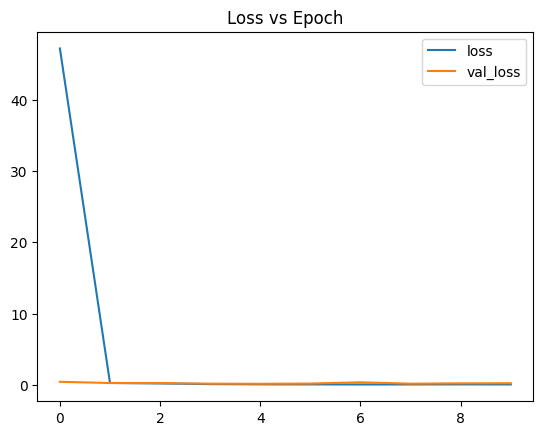

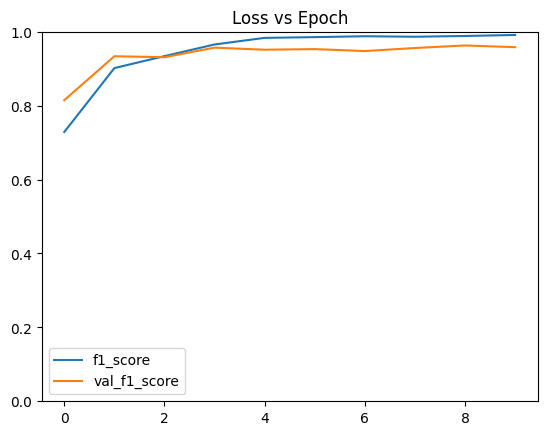

In [50]:
df = pd.DataFrame(history.history)
df['f1_score'] = df['f1_score'].apply(lambda x: x[0])
df['val_f1_score'] = df['val_f1_score'].apply(lambda x: x[0])
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")
df.plot(y=["f1_score", "val_f1_score"], title="Loss vs Epoch",ylim=(0,1))

###Resultados con el conjunto de prueba

1/1 [==============================] - 0s 67ms/step


F1-score en el conjunto de prueba: 0.96


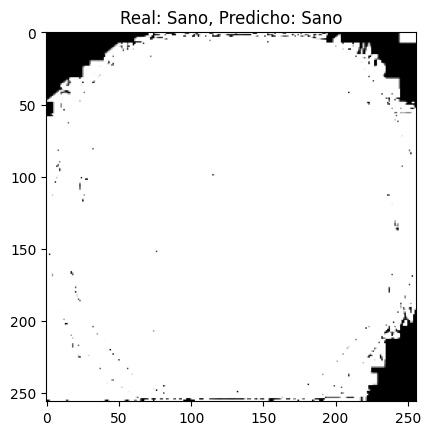

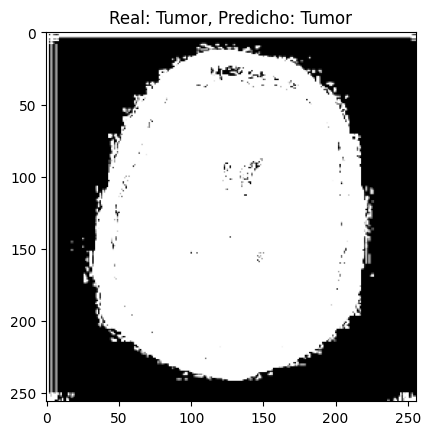

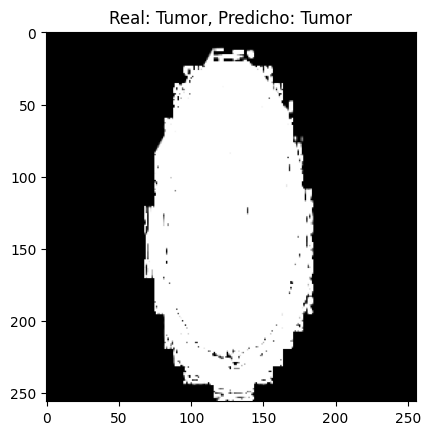

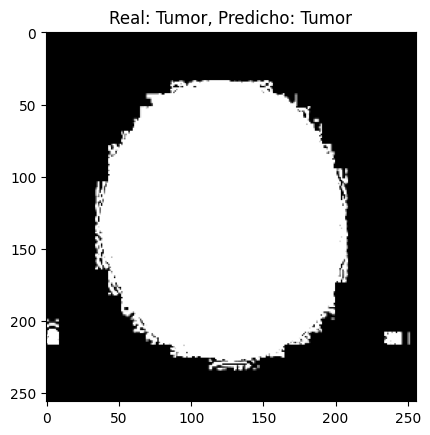

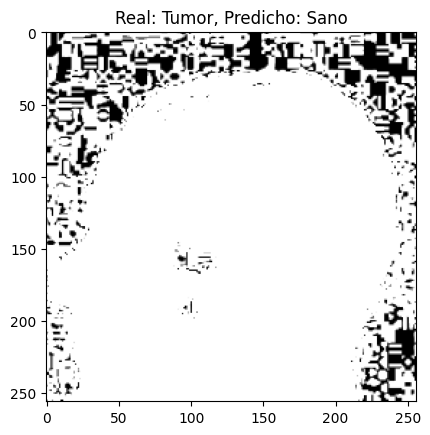

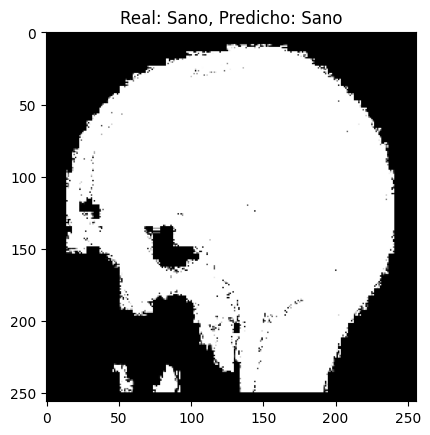

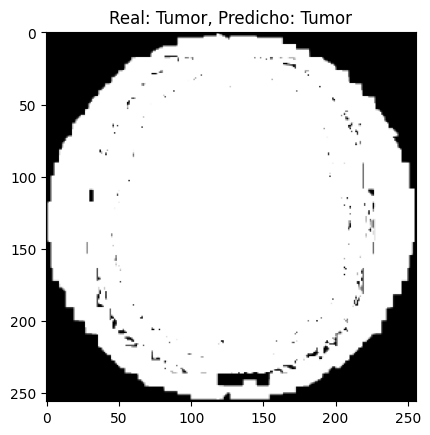

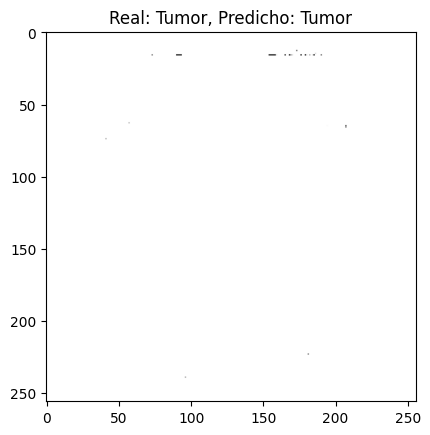

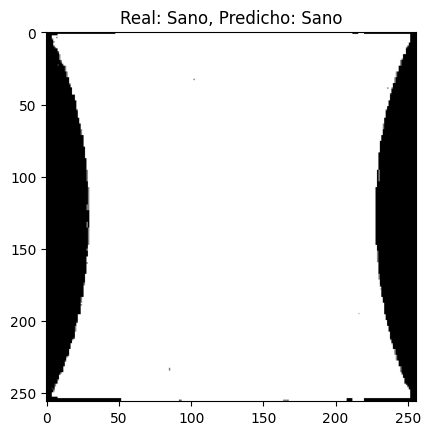

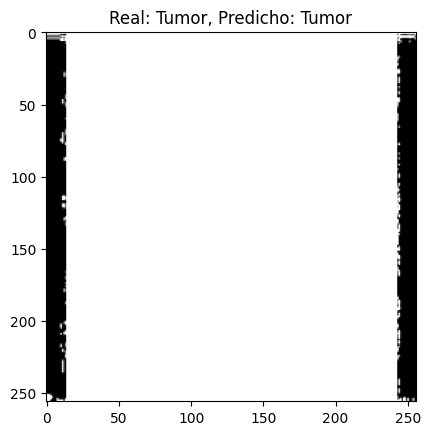

In [56]:

images = []
true_labels = []
predicted_labels = []
for x, y in test:
    predictions = model.predict(x)
    images.extend(x)
    true_labels.extend(y)
    predicted_labels.extend(predictions)

true_binary_labels = [1 if label[0] == 1 else 0 for label in true_labels]
predicted_binary_labels = [1 if label[0] >= 0.5 else 0 for label in predicted_labels]

f1 = f1_score(true_binary_labels, predicted_binary_labels)
print(f'F1-score en el conjunto de prueba: {f1:.2f}')

for i in range(10):
    image = images[i]
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]
    true_class = 'Tumor' if true_label[0] == 1 else 'Sano'
    predicted_class = 'Tumor' if predicted_label[0] >= 0.5 else 'Sano'
    plt.imshow(image)
    plt.title(f'Real: {true_class}, Predicho: {predicted_class}')
    plt.show()


Después de utilizar el conjunto de prueba para terminar la evaluación de la red podemos observar que el desempeño visto anteriormente se mantiene con F1 Scores de 98, 97 y 96% para los conjuntos de entrenamiento, validación y prueba respectivamente.
Esto nos indica que logramos robustecer el modelo, evitando el ligero sobreentrenamiento que habiamos detectado. Además ahorramo tiempo de entrenamiento y evitamos sobreentrenamiento gracias al early stopping y nos aseguramos regresar a los mejores parámetros seguidos.

##Conclusión

En conclusión, el problema parece ser relativamente sencillo para una red neuronal convolución ya que una arquitectura sencilla obtuvo buenos resultados y permitió que el enfoque fuera puramente en la optmización del funcionamiento de la red. Finalmente, con unos peuqeños ajustes de parametros termino siendo suficiente para robustecer a la red.

Finalmente, el siguiente paso para un modelo de este tipo sería su implementación y utlización práctica, además se podría considerar útil probar el modelo con datos de menor calidad para retarlo y demostrar el nivel de robustez que parece tener.